In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numbers
import random

In [3]:
import scipy.stats

### Relevant functions

In [4]:
# Copied from Vectorized EMD.ipynb
from typing import List
import lap

# return distance only, not result
def earth_mover_distance_1(samples1: np.ndarray, samples2: np.ndarray, radixes: List[int], question_types: List[str]):
    ## Sanity check
    if (samples1.shape != samples2.shape):
        print("samples1 and samples2 shape not the same!")
        return

    # N: number of samples in both samples1 and samples2
    numberOfSamples = samples1.shape[0]
    # Q: number of questions in the survey
    numberOfQuestions = samples1.shape[1]

    if (numberOfQuestions != len(radixes)):
        print("radixes length not match!")
        return

    if (numberOfQuestions != len(question_types)):
        print("question_types length not match!")
        return

    ## Calculating distance matrix
    # distance matrix (shape N*N). Element distance[x][y] denotes distance between x-th element in samples1 and y-th element in samples2
    distance = np.zeros((numberOfSamples, numberOfSamples))
    # Memoizes and eliminates unnecessary computations. (z, valueInX) => np.ndarray of cost
    memoMap = {}

    for z in range(0, numberOfQuestions):
        # radio and checkbox question: distance = 1 if different else 0
        if question_types[z] == "radio" or question_types[z] == "checkbox":
            # TODO: probably the following loop can be parallelized?
            for x in range(0, samples1.shape[0]):
                value = samples1[x][z]  # value of samples1 in this col
                
                # Note that we can memoize the operation here: for the same value, the cost contribution of *this question* will always be the same when comparing across entire samples2
                if (z, value) in memoMap.keys():
                    distance[x] += memoMap[(z, value)]
                else:
                    # Note that this operation is vectorized: numpy has builtin function for comparing & setting values
                    memo = np.where(samples2[:, z] == value, 0, 1)
                    memoMap[(z, value)] = memo
                    distance[x] += memo

        # estimate question: distance = absolute difference / radix
        else:
            radix = radixes[z]
            for x in range(0, samples1.shape[0]):
                value = samples1[x][z]
                if (z, value) in memoMap.keys():
                    distance[x] += memoMap[(z, value)]
                else:
                    # Note that this operation is vectorized: numpy has builtin function for subtracting and division across entire row
                    memo = np.abs((samples2[:, z] - value)/radix)
                    memoMap[(z, value)] = memo
                    distance[x] += memo

    ## Find minimum distance matching (i.e. EMD) with Jonker–Volgenant algorithm
    return distance

# return EMD
def earth_mover_distance(samples1: np.ndarray, samples2: np.ndarray, radixes: List[int], question_types: List[str]):
    distance = earth_mover_distance_1(samples1, samples2, radixes, question_types)
    return lap.lapjv(distance)[0]

In [5]:
# n is number of samples to create
# radixes describes what a sample should look like: possibilities for each sample
def createSamples(n, radixes):

    samples = []
    length = len(radixes)

    for x in range(n):
        sample = []
        for y in range(length):
            # for each item, randomly choose using probabilities
            radix = radixes[y]
            newNumber = random.randint(0, radix-1)
            sample.append(newNumber)
        samples.append(sample)

    return np.array(samples)

### Data Preprocessing

In [21]:
df_temp = pd.read_csv("../../../PEW_1k.csv")

In [15]:
df_ans.columns

Index(['Worker ID', 'cost', 'updated', 'round', 'Saving for the future',
       'Paying for college', 'Buying a home', 'Finding a spouse or partner',
       'Finding a job', 'Getting into college',
       'Staying in touch with family and friends',
       'Do you currently live in the United States?', 'What is your age?',
       'What do you think the median home price in the US is in 2021?',
       'What do you think is the average household income in the US for 2021?',
       'What is the gas price in your area?',
       'What is the acceptance percentage when applying to Harvard University as an undergraduate?',
       'What is the number of states in the United States?',
       'In the US, about how many people do you think use the internet in 2021, in millions?',
       'What do you think is the average annual tuition of public colleges in the US in 2021?',
       'In what year will the US will hold its next presidential election?'],
      dtype='object')

In [22]:
df_ans = df_temp.rename(columns={
    'Worker ID': 'id',
    'Saving for the future': 'saving',
    'Paying for college': 'tuition',
    'Buying a home': 'home',
    'Finding a spouse or partner': 'spouse',
    'Finding a job': 'job',
    'Getting into college': 'college',
    'Staying in touch with family and friends': 'comm',
    'Do you currently live in the United States?': 'us',
    'What is your age?': 'age',
    'What do you think the median home price in the US is in 2021?': 'e_home',
    'What do you think is the average household income in the US for 2021?': 'e_income',
    'What is the gas price in your area?': 'e_gas',
    'What is the acceptance percentage when applying to Harvard University as an undergraduate?': 'e_harvard',
    'What is the number of states in the United States?': 'e_state',
    'In the US, about how many people do you think use the internet in 2021, in millions?': 'e_internet',
    'What do you think is the average annual tuition of public colleges in the US in 2021?': 'e_tuition',
    'In what year will the US will hold its next presidential election?': 'e_election'
}, errors="raise").drop(columns=['cost','updated','round'])
df_ans

,id,saving,tuition,home,spouse,job,college,comm,us,age,e_home,e_income,e_gas,e_harvard,e_state,e_internet,e_tuition,e_election
0,ARPBDM5QZ4XQC,Harder,Easier,Harder,Easier,Easier,Easier,Easier,Yes,44.0,150000.0,35000.0,3.99,15.0,50.0,250.0,15000.0,2024.0
1,A1YSYI926BBOHW,Harder,Harder,Harder,Easier,Same,Same,Harder,Yes,38.0,315000.0,49000.0,5.29,3.0,50.0,300.0,14000.0,2024.0
2,ASVPTWBAE7UJ,Easier,Easier,Easier,Easier,Same,Easier,Easier,Yes,25.0,4000.0,50000.0,4500.00,4000.0,3000.0,5000.0,4000.0,4500.0
3,A1DMXEJGJY02E1,Harder,Harder,Harder,Same,Harder,Same,Easier,Yes,34.0,250000.0,40000.0,3.65,20.0,50.0,5.0,15000.0,2024.0
4,A2HXOWSUZCQLB6,Same,Harder,Same,Easier,Same,Harder,Easier,Yes,40.0,14.0,6.0,3.00,6.0,2.0,6.0,2021.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A2Z3BFRLKZIM67,Same,Easier,Same,Same,Same,Same,Easier,Yes,25.0,500.0,50000.0,200.00,80.0,50.0,500.0,500.0,2024.0
996,A1651250EKM6LE,Harder,Easier,Harder,Easier,Same,Easier,Same,Yes,30.0,20000.0,3000.0,200.00,2520000.0,50.0,2000.0,60000.0,3000.0
997,A3UHDPXC5EWOKC,Harder,Same,Harder,Harder,Same,Harder,Harder,Yes,25.0,50000.0,75000.0,85.00,87.0,42.0,3.0,250000.0,2025.0
998,A17I9PP3CH0121,Same,Easier,Easier,Easier,Easier,Same,Same,Yes,34.0,60000.0,35000.0,5.00,65.0,50.0,290.0,7500.0,2026.0


# Some interesting Answers

916


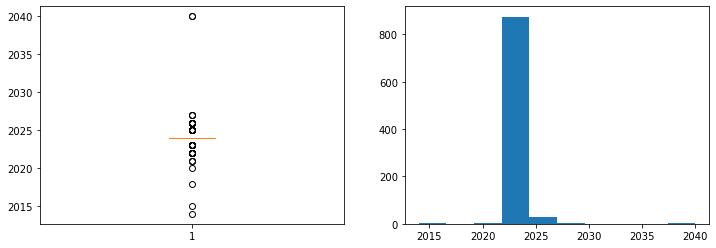

2024.0 2024.0
2024.0 2024.0


In [408]:
fix, axs = plt.subplots(1,2, figsize=(12,4))

sample = df_ans["e_election"][df_ans["e_election"].between(2010,2040)]
print(len(sample))

axs[0].boxplot(sample)
axs[1].hist(sample)

plt.show()

q3, q1 = np.percentile(sample, [75, 25])
IQR = q3 - q1  # Inter-Quartile Range

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print(lower_bound, upper_bound)
print(q1, q3)

In [422]:
pd.set_option('display.max_rows', None)
display(df_ans[(df_ans["e_election"] != 2024) & (df_ans["e_election"].between(2010,2040))].sort_values("e_election"))
pd.set_option('display.max_rows', 10)

,id,saving,tuition,home,spouse,job,college,comm,us,age,e_home,e_income,e_gas,e_harvard,e_state,e_internet,e_tuition,e_election
879,A1OSJTNI18VOKL,Harder,Harder,Harder,Harder,Harder,Harder,Easier,No,30.0,2500000.0,25000.0,71.000,80.00,50.0,5.000000e+05,2500.00,2014.0
8,A2L06D9Z12JCYV,Easier,Easier,Harder,Same,Easier,Easier,Harder,Yes,31.0,60000.0,50000.0,40000.000,70000.00,2016.0,2.021000e+03,2021.00,2015.0
723,A33NRKW19AWXM2,Harder,Harder,Harder,Easier,Easier,Easier,Easier,Yes,28.0,500000.0,800000.0,100.000,25.00,50.0,5.000000e+01,80000.00,2018.0
108,A2M2HLOKLN7FP4,Harder,Harder,Easier,Harder,Harder,Harder,Harder,Yes,32.0,9000.0,90000.0,100.000,100.00,50.0,5.000000e+01,98.00,2020.0
169,A31OGPLSM90UIU,Harder,Easier,Same,Harder,Same,Easier,Same,Yes,34.0,900000.0,90000.0,1000.000,80.00,50.0,8.900000e+03,89000.00,2021.0
586,A1DL8I2TKBHO5A,Harder,Same,Harder,Harder,Harder,Same,Easier,Yes,36.0,200000.0,60000.0,4.500,1.00,50.0,1.750000e+02,25000.00,2021.0
136,A2NXZIK5NTML18,Easier,Easier,Harder,Harder,Harder,Same,Same,Yes,36.0,99000.0,89000.0,1000.000,80.00,50.0,1.000000e+06,89000.00,2021.0
880,A149B8HKDLQ53B,Harder,Same,Same,Harder,Same,Harder,Same,Yes,25.0,225900.0,39000.0,3.259,70.00,50.0,1.500000e+07,150000.00,2022.0
687,A1T0ND039EWAVV,Harder,Harder,Harder,Harder,Harder,Harder,Easier,Yes,43.0,150000.0,35000.0,3.490,5.00,50.0,1.000000e+02,60000.00,2022.0
351,A57A6U59E4JJY,Harder,Harder,Harder,Harder,Same,Same,Same,Yes,31.0,350000.0,50000.0,5.355,55.00,50.0,5.000000e+02,10000.00,2022.0


In [392]:
df_ans[df_ans["e_internet"] > 10000000000]

,id,saving,tuition,home,spouse,job,college,comm,us,age,e_home,e_income,e_gas,e_harvard,e_state,e_internet,e_tuition,e_election
754,A118KQORTQPWYY,Harder,Same,Harder,Same,Easier,Same,Easier,Yes,50.0,300000.0,62000.0,3.40,10.0,50.0,1.000000e+11,22000.0,2024.0
772,AX1YV8YNRW0GB,Harder,Same,Harder,Same,Harder,Same,Easier,Yes,31.0,300000.0,50000.0,4.81,5.0,50.0,2.000000e+10,25000.0,2024.0
912,A353OA9PNMXKV0,Harder,Harder,Harder,Harder,Same,Same,Easier,Yes,39.0,300000.0,40000.0,3.55,50.0,50.0,1.000000e+11,50000.0,2023.0


<AxesSubplot:>

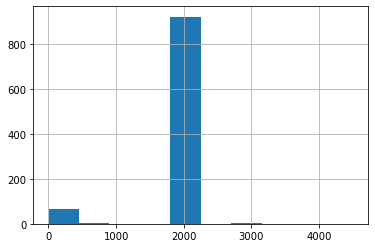

In [31]:
df_ans['e_election'][df_ans['e_election'] < 5000].hist()

In [46]:
df_ans['e_election'][~df_ans['e_election'].between(2020,2100)]

2       4500.0
4          3.0
7          1.0
8       2015.0
10         4.0
        ...   
974       70.0
979       66.0
985    50000.0
993       44.0
996     3000.0
Name: e_election, Length: 85, dtype: float64

In [47]:
df_ans['e_election'][df_ans['e_election'].between(2020,2100) & (df_ans['e_election'] != 2024.0)]

24     2025.0
51     2050.0
75     2025.0
108    2020.0
124    2023.0
        ...  
968    2026.0
986    2023.0
991    2026.0
997    2025.0
998    2026.0
Name: e_election, Length: 62, dtype: float64

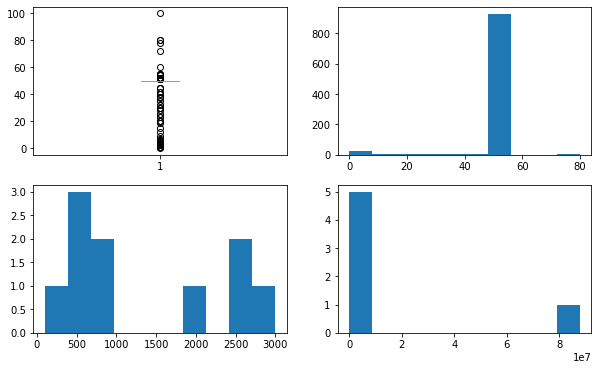

In [92]:
fig, axs = plt.subplots(2,2,figsize=(10,6))

axs[0][0].boxplot(df_ans['e_state'][df_ans['e_state'].between(0,100)])
axs[0][1].hist(df_ans['e_state'][df_ans['e_state'] < 100])
axs[1][0].hist(df_ans['e_state'][df_ans['e_state'].between(100,10000)])
axs[1][1].hist(df_ans['e_state'][df_ans['e_state']>10000])

plt.show()

-29.500000000000004 57.7


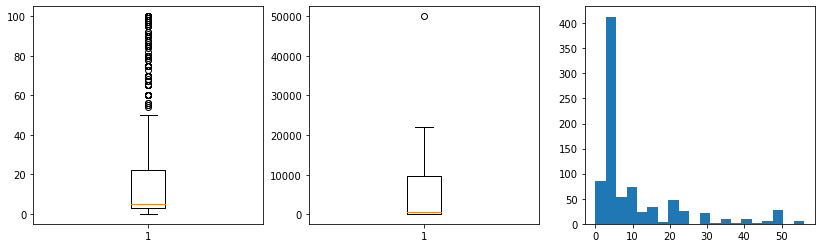

In [104]:
fig, axs = plt.subplots(1,3,figsize=(14,4))

axs[0].boxplot(df_ans['e_harvard'][df_ans['e_harvard'].between(0,100)])
axs[1].boxplot(df_ans['e_harvard'][df_ans['e_harvard'].between(100,60000)])


# Non-outlier hist
q3, q1 = np.percentile(df_ans['e_harvard'], [75, 25])
IQR = q3 - q1  # Inter-Quartile Range

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print(lower_bound, upper_bound)

axs[2].hist(df_ans['e_harvard'][df_ans['e_harvard'].between(lower_bound, upper_bound, inclusive="both")], bins=20)

plt.show()

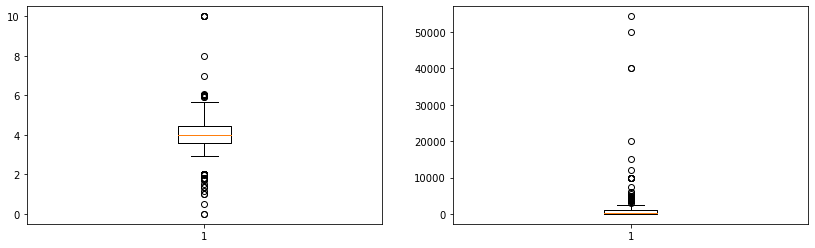

In [106]:
fig, axs = plt.subplots(1,2,figsize=(14,4))

axs[0].boxplot(df_ans['e_gas'][df_ans['e_gas'].between(0,10)])
axs[1].boxplot(df_ans['e_gas'][df_ans['e_gas'].between(10,100000)])

plt.show()

# Predicate filtering

In [423]:
p_home = (df_ans["e_home"] > 0)  & (df_ans["e_home"] < 784750)
p_income = (df_ans["e_income"] > 0) & (df_ans["e_income"] < 120000)
p_gas = (df_ans["e_gas"] > 3) & (df_ans["e_gas"] < 8)
p_harvard = (df_ans["e_harvard"] > 0)  & (df_ans["e_harvard"] < 10)
p_state = (df_ans["e_state"] == 50)
p_internet = (df_ans["e_internet"] > 0) & (df_ans["e_internet"] < 400)
p_tuition = (df_ans["e_tuition"] > 5000)  & (df_ans["e_tuition"] < 40000)
p_election = (df_ans["e_election"] == 2024) | (df_ans["e_election"] == 2020)

In [443]:
p_total = np.array([p_home,p_income,p_gas,p_harvard,p_state,p_internet,p_tuition,p_election]).sum(axis=0)
idx_truth = p_total >= 6 ## at most two wrong
idx_truth.sum()

741

In [464]:
idx_truth_strict = p_total >= 7 ## at most one wrong
idx_truth_strict.sum()

516

# Radix & Outlier (IQR approach)

In [113]:
np.interp([2,4,5.5,100, -0.3], [0, 5], [0,10], left=11,right=11)

array([ 4.,  8., 11., 11., 11.])

In [184]:
question_types = ["radio", "radio", "radio", "radio", "radio", "radio", "radio", "radio", "estimate", 
                  "estimate", "estimate", "estimate", "estimate", "estimate", "estimate", "estimate", "estimate"]

In [261]:
sample_ans = np.zeros((1000,17), dtype=int)

for index, col in enumerate(df_ans.columns):
    if col == "id":
        continue  # drop ID column
    
    if question_types[index-1] == "radio":
        sample_ans[:,index-1] = df_ans[col].map({
            # dictionary for radio question
            'Easier': 0,
            'Same': 1,
            'Harder': 2,
            # dictionary for boolean radio
            'Yes': 1,
            'No': 0,
        }).astype(int)
    elif question_types[index-1] == "estimate":
        # they are put into 10 bins here
        
        q3, q1 = np.percentile(df_ans[col], [75, 25])
        IQR = q3 - q1  # Inter-Quartile Range

        upper_bound = q3 + 1.5 * IQR
        lower_bound = q1 - 1.5 * IQR
        
        # note that with numpy we do not need to handle the case of upper_bound == lower_bound
        
        arr_tmp = np.digitize(df_ans[col], np.linspace(lower_bound, upper_bound, 21))
        arr_tmp[df_ans[col] < lower_bound] = 0  # lower outliers
        arr_tmp[df_ans[col] == upper_bound] = 20 # upper bound should be 20 instead of 21
        arr_tmp[df_ans[col] > upper_bound] = 21 # upper outliers
        
        sample_ans[:,index-1] = arr_tmp.astype(int)
    else:
        print("Not handled:", index-1, col, question_types[index-1])

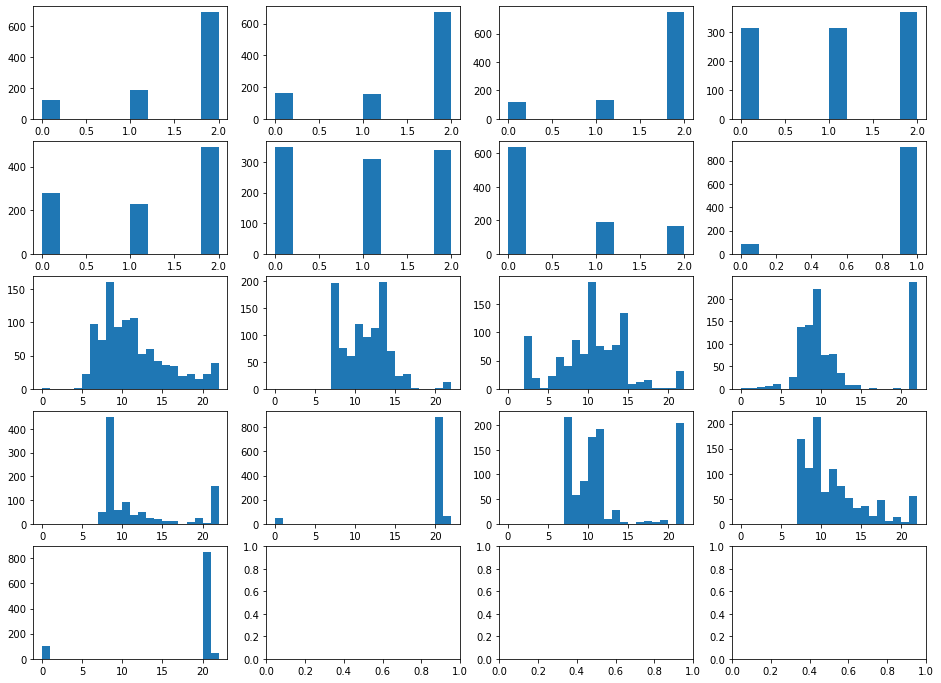

In [274]:
fig, axs = plt.subplots(5,4, figsize=(16,12))

for i in range(0,17):
    row = i // 4
    col = i % 4
    
    if question_types[i] == "estimate":
        axs[row][col].hist(sample_ans[:,i], bins=np.arange(0,23))
    else:
        axs[row][col].hist(sample_ans[:,i])

In [264]:
radixes = [3,3,3,3,3,3,3,2] + [20]*9
radixes

[3, 3, 3, 3, 3, 3, 3, 2, 20, 20, 20, 20, 20, 20, 20, 20, 20]

# Denoise

In [208]:
SAMPLE_SIZE = 1000

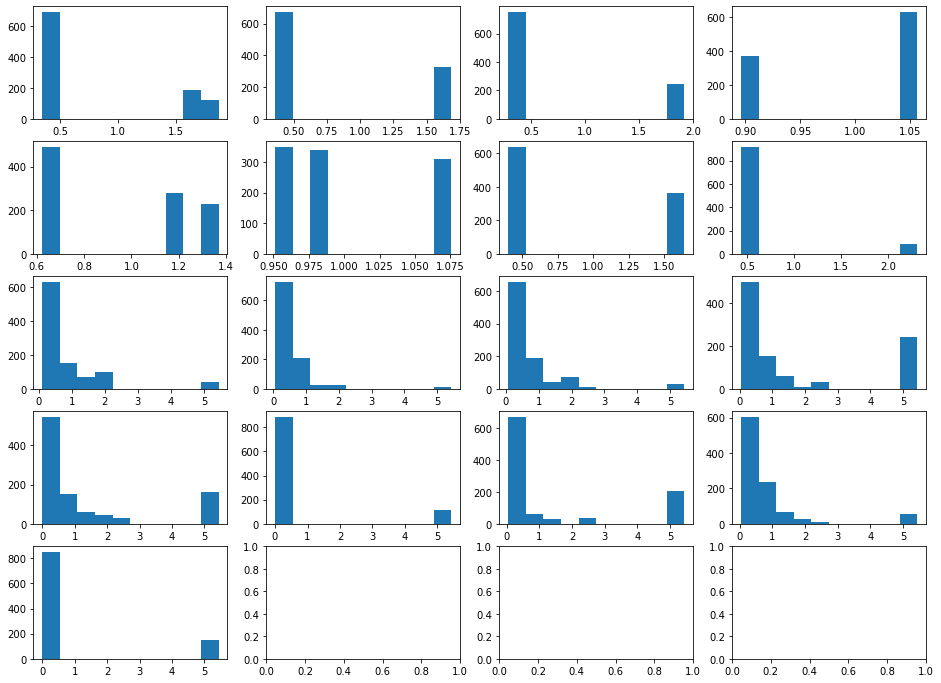

In [285]:
fig, axs = plt.subplots(5,4, figsize=(16,12))

for index_q in range(0,17):
    row = index_q // 4
    col = index_q % 4
    
    ans_q = sample_ans[:,index_q]
    bincount_q = np.bincount(ans_q)
    rad = radixes[index_q]
    
    if question_types[index_q] == "estimate":
        prob_q = np.select(
                [ans_q==i for i in np.arange(0,rad+1)], # estimates have to +1 ==> bins are 1...20
                # note that if there is no upper outlier, this may fail because of different sizes, need to find a way to pad following array
                np.power(np.e, (1/rad - bincount_q[:rad+1]/SAMPLE_SIZE)*rad),
                2 * np.e # handle higher outlier
            )
        prob_q[ans_q == 0] = 2 * np.e # handle lower outlier 
    else:
        prob_q = np.select(
            [ans_q==i for i in np.arange(0,rad)],
            np.power(np.e, (1/rad - bincount_q[:rad]/SAMPLE_SIZE)*rad),
            np.e # handle higher outlier
        )
    
    axs[row][col].hist(prob_q)
    
plt.show()

In [305]:
def denoise(sample_ans, radixes, question_types):
    SAMPLE_SIZE = len(sample_ans)
    prob_random = np.zeros((SAMPLE_SIZE,))

    for index_q in range(0,len(radixes)):
        ans_q = sample_ans[:,index_q]
        bincount_q = np.bincount(ans_q)
        rad = radixes[index_q]

        if question_types[index_q] == "estimate":
            prob_q = np.select(
                    [ans_q==i for i in np.arange(0,rad+1)], # estimates have to +1 ==> bins are 1...20
                    # note that if there is no upper outlier, this may fail because of different sizes, need to find a way to pad following array
                    np.power(np.e, (1/rad - bincount_q[:rad+1]/SAMPLE_SIZE)*rad),
                    2 * np.e # handle higher outlier
                )
            prob_q[ans_q == 0] = 2 * np.e # handle lower outlier 
        else:
            prob_q = np.select(
                [ans_q==i for i in np.arange(0,rad)],
                np.power(np.e, (1/rad - bincount_q[:rad]/SAMPLE_SIZE)*rad),
                np.e # handle higher outlier
            )

        axs[row][col].hist(prob_q)
        prob_random += prob_q
    
    return prob_random

# Filtered according to all

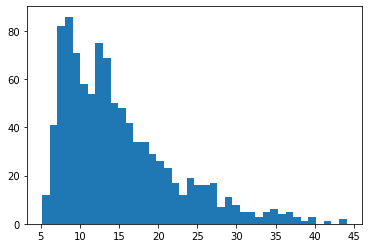

In [287]:
prob_random_all = denoise(sample_ans, radixes, question_types)

plt.hist(prob_random_all, bins=40)
plt.show()

In [457]:
np.percentile(prob_random_all, 50)

13.276509586838106

{'whiskers': [<matplotlib.lines.Line2D at 0x157a67b80>,
 'caps': [<matplotlib.lines.Line2D at 0x157a7e160>,
 'boxes': [<matplotlib.lines.Line2D at 0x157a67850>],
 'medians': [<matplotlib.lines.Line2D at 0x157a7e700>],
 'fliers': [<matplotlib.lines.Line2D at 0x157a7e9d0>],
 'means': []}

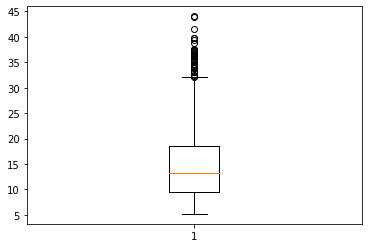

In [456]:
plt.boxplot(prob_random_all)

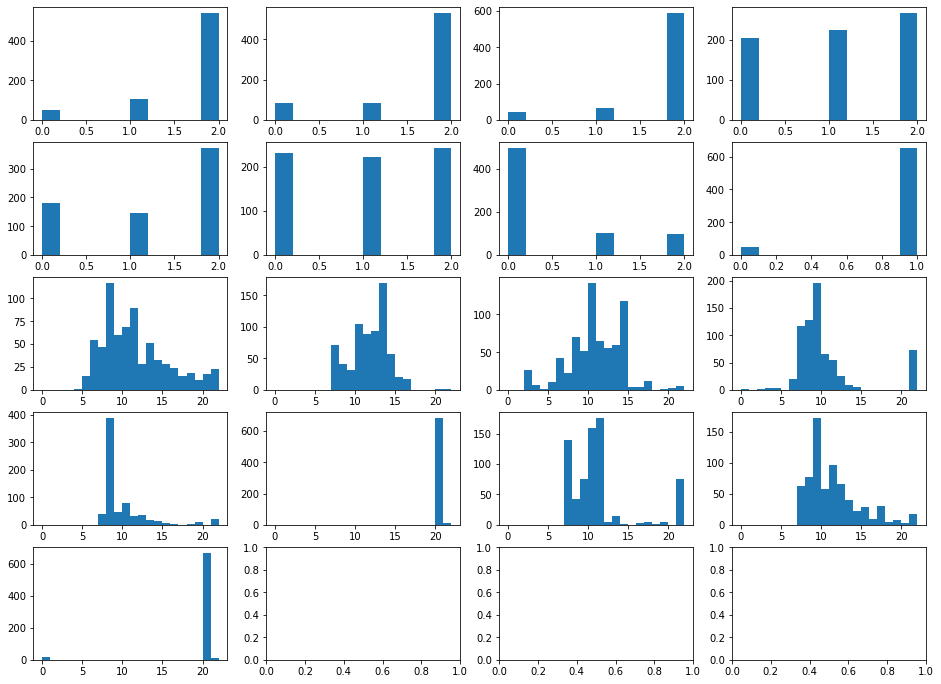

In [297]:
threshold = np.percentile(prob_random_all, 70)
sample_filtered = sample_ans[prob_random_all < threshold]

fig, axs = plt.subplots(5,4, figsize=(16,12))
for i in range(0,17):
    row = i // 4
    col = i % 4
    
    if question_types[i] == "estimate":
        axs[row][col].hist(sample_filtered[:,i], bins=np.arange(0,23))
    else:
        axs[row][col].hist(sample_filtered[:,i])

# Filtered without control questions

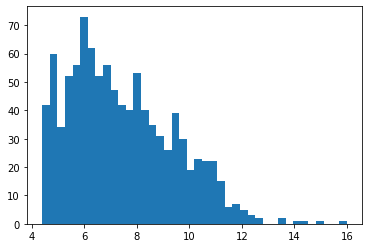

In [298]:
prob_random_q = denoise(sample_ans[:,:9], radixes[:9], question_types[:9])

plt.hist(prob_random_q, bins=40)
plt.show()

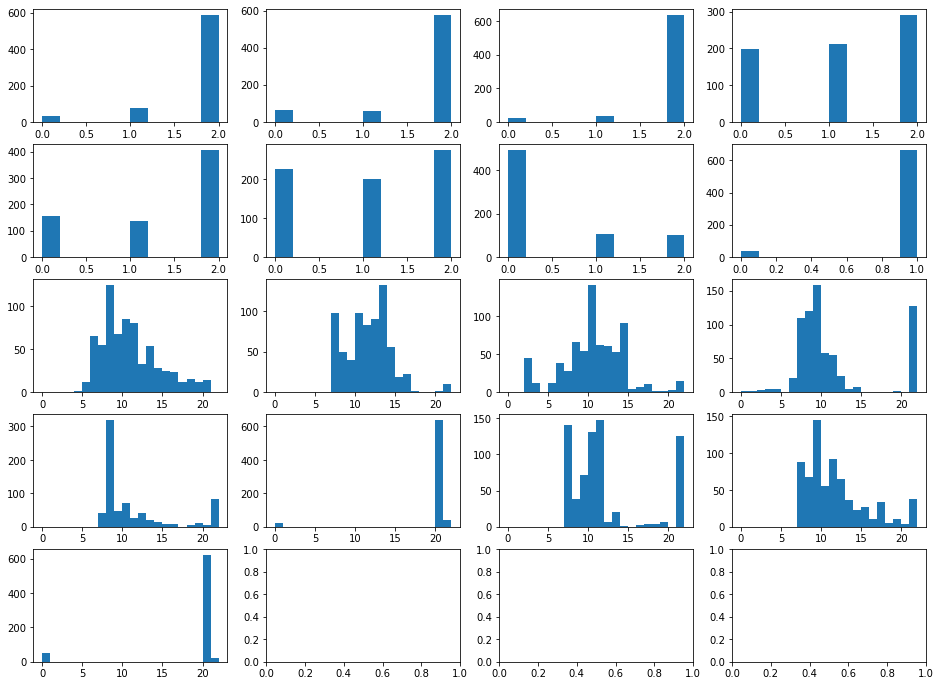

In [299]:
threshold = np.percentile(prob_random_q, 70)
sample_filtered = sample_ans[prob_random_q < threshold]

fig, axs = plt.subplots(5,4, figsize=(16,12))
for i in range(0,17):
    row = i // 4
    col = i % 4
    
    if question_types[i] == "estimate":
        axs[row][col].hist(sample_filtered[:,i], bins=np.arange(0,23))
    else:
        axs[row][col].hist(sample_filtered[:,i])

# Filtered with only control questions

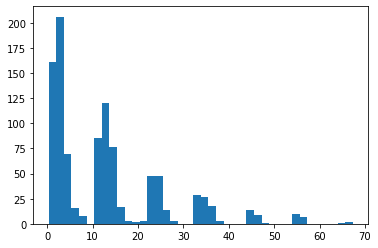

In [303]:
prob_random_control = denoise(sample_ans[:,9:], radixes[9:], question_types[9:])

plt.hist(prob_random_control, bins=40)
plt.show()

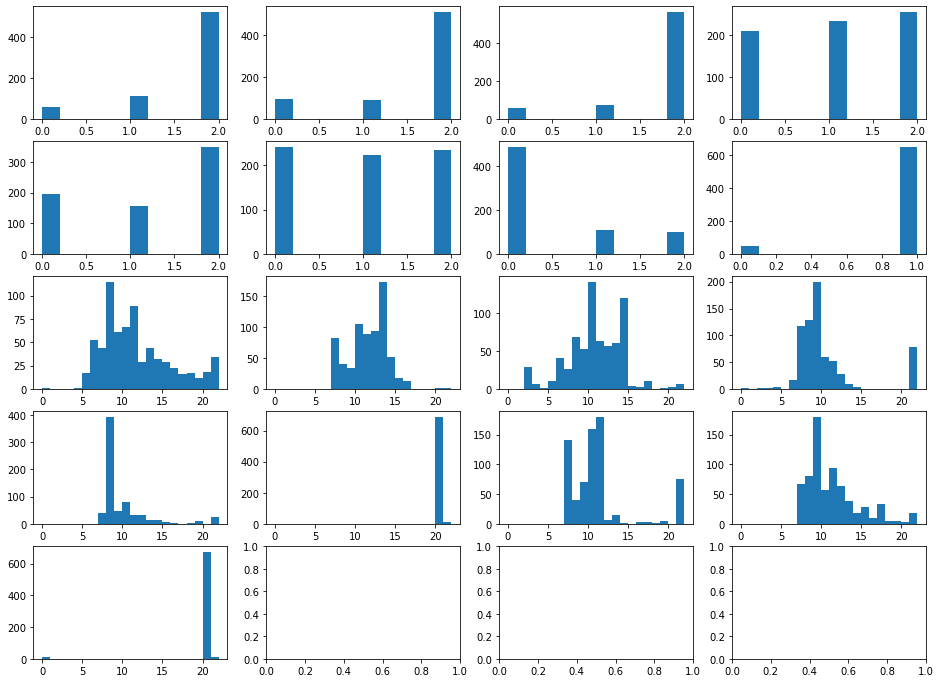

In [306]:
threshold = np.percentile(prob_random_control, 70)
sample_filtered = sample_ans[prob_random_control < threshold]

fig, axs = plt.subplots(5,4, figsize=(16,12))
for i in range(0,17):
    row = i // 4
    col = i % 4
    
    if question_types[i] == "estimate":
        axs[row][col].hist(sample_filtered[:,i], bins=np.arange(0,23))
    else:
        axs[row][col].hist(sample_filtered[:,i])

# Precision-Recall Curve

Using only control question, 70% as ground truth
Using normal questions as test

In [321]:
threshold_control = np.percentile(prob_random_control, 70)
ground_truth = prob_random_control < threshold

In [444]:
ground_truth = idx_truth

In [445]:
precision = []
recall = []

for p in np.arange(1,101,1):
    threshold_q = np.percentile(prob_random_q, p)
    test = prob_random_q < threshold_q
    
    # tp / tp+fp
    precision.append(np.logical_and(test, ground_truth).sum() / test.sum())
    # tp / tp+fn
    recall.append(np.logical_and(test, ground_truth).sum() / ground_truth.sum())

Text(0, 0.5, 'precisioin')

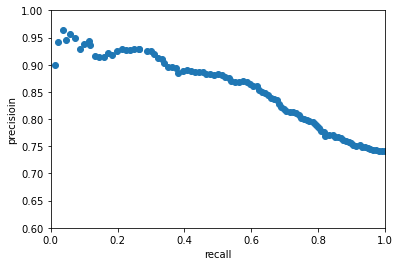

In [449]:
plt.scatter(recall, precision)
plt.xlim([0,1])
plt.ylim([0.6,1])
plt.xlabel("recall")
plt.ylabel("precisioin")

In [450]:
precision = []
recall = []

for p in np.arange(1,101,1):
    threshold_all = np.percentile(prob_random_all, p)
    test = prob_random_all < threshold_all
    
    # tp / tp+fp
    precision.append(np.logical_and(test, ground_truth).sum() / test.sum())
    # tp / tp+fn
    recall.append(np.logical_and(test, ground_truth).sum() / ground_truth.sum())

Text(0, 0.5, 'precisioin')

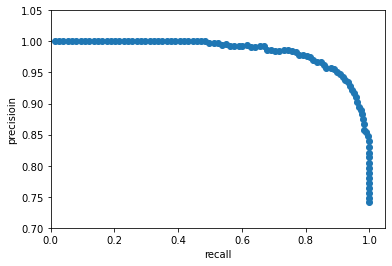

In [462]:
plt.scatter(recall, precision)
plt.xlim([0,1.05])
plt.ylim([0.70,1.05])
plt.xlabel("recall")
plt.ylabel("precisioin")

Text(0, 0.5, 'precisioin')

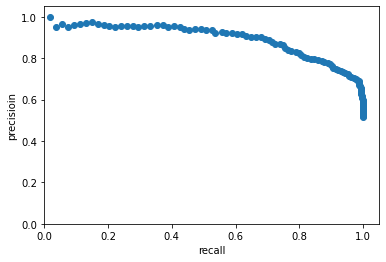

In [470]:
precision = []
recall = []

for p in np.arange(1,101,1):
    threshold_all = np.percentile(prob_random_all, p)
    test = prob_random_all < threshold_all
    
    # tp / tp+fp
    precision.append(np.logical_and(test, idx_truth_strict).sum() / test.sum())
    # tp / tp+fn
    recall.append(np.logical_and(test, idx_truth_strict).sum() / idx_truth_strict.sum())
    
plt.scatter(recall, precision)
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel("recall")
plt.ylabel("precisioin")

In [469]:
np.logical_and(test, idx_truth_strict).sum() / test.sum()

1.0

750
Precision:  0.928
Recall:  0.9392712550607287


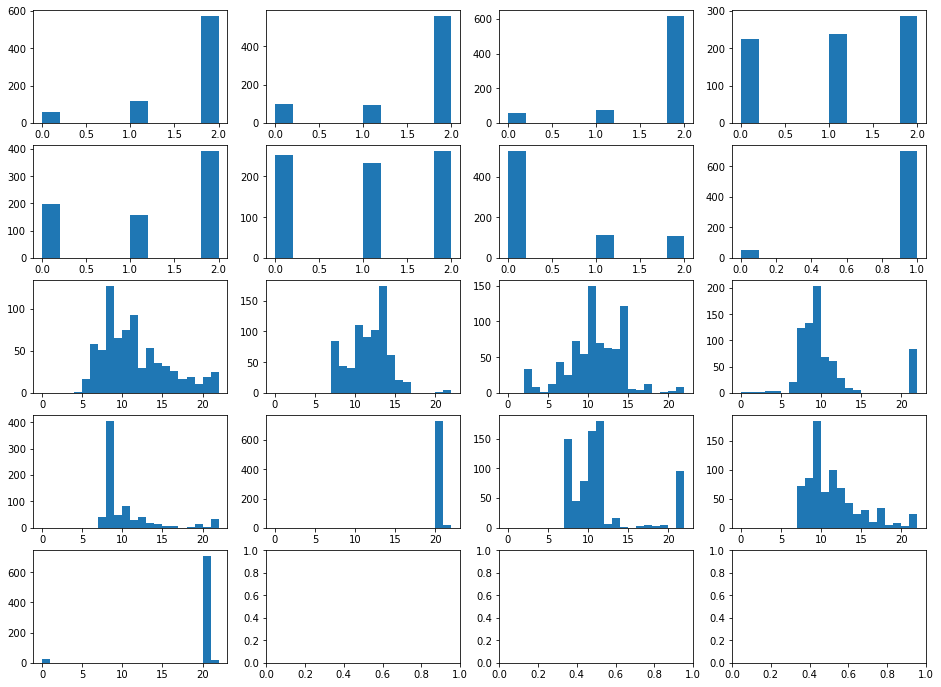

In [463]:
test = prob_random_all < np.percentile(prob_random_all, 75)

print(test.sum())
print("Precision: ", np.logical_and(test, ground_truth).sum() / test.sum())
print("Recall: ", np.logical_and(test, ground_truth).sum() / ground_truth.sum())

sample_filtered = sample_ans[test]
fig, axs = plt.subplots(5,4, figsize=(16,12))
for i in range(0,17):
    row = i // 4
    col = i % 4
    
    if question_types[i] == "estimate":
        axs[row][col].hist(sample_filtered[:,i], bins=np.arange(0,23))
    else:
        axs[row][col].hist(sample_filtered[:,i])

# Else